# Installations

In [ ]:
pip install ir_datasets

In [ ]:
pip install ir_measures

# Imports

In [ ]:
import math
import torch
import ir_datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util 
from ir_measures import Qrel, ScoredDoc, nDCG, MAP, Recall, calc_aggregate

# Dataset

In [4]:
dataset = ir_datasets.load("neuclir/1/ru/trec-2023")
dataset

Dataset(id='neuclir/1/ru/trec-2023', provides=['docs', 'queries', 'qrels'])

In [5]:
russian_documents = [(doc.doc_id, doc.title) for doc in dataset.docs_iter()]

[INFO] If you have a local copy of https://huggingface.co/datasets/neuclir/neuclir1/resolve/main/data/rus-00000-of-00001.jsonl.gz?download=true, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/3aabc798a3b5dd92d7c47db9521870b1
[INFO] [starting] https://huggingface.co/datasets/neuclir/neuclir1/resolve/main/data/rus-00000-of-00001.jsonl.gz?download=true
[INFO] [finished] https://huggingface.co/datasets/neuclir/neuclir1/resolve/main/data/rus-00000-of-00001.jsonl.gz?download=true: [03:07] [4.50GB] [24.0MB/s]


In [23]:
english_queries = [(query.query_id, query.title) for query in dataset.queries_iter()]

[INFO] If you have a local copy of https://trec.nist.gov/data/neuclir/2023/neuclir-2023-qrels.final.tar.gz, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/cea4ff3d9eba612c7119e6490217d4e1
[INFO] [starting] https://trec.nist.gov/data/neuclir/2023/neuclir-2023-qrels.final.tar.gz
[INFO] [finished] https://trec.nist.gov/data/neuclir/2023/neuclir-2023-qrels.final.tar.gz: [00:02] [6.02MB] [2.79MB/s]
[INFO] [starting] https://trec.nist.gov/data/neuclir/2023/neuclir-2023-topics.0605.jsonl
[INFO] [finished] https://trec.nist.gov/data/neuclir/2023/neuclir-2023-topics.0605.jsonl: [00:01] [684kB] [530kB/s]


# Functions

In [79]:
def rbp(retrieved_results, qrels, p=0.8):
    from collections import defaultdict
    qrels_dict = defaultdict(set)

    # Process qrels into a dictionary
    for qrel in qrels:
        query_id = qrel.query_id
        doc_id = qrel.doc_id
        relevance = qrel.relevance
        if relevance > 0:  # Only consider relevant documents (rel >= 1)
            qrels_dict[query_id].add(doc_id)

    rbp_scores = {}
    for query_id, retrieved_docs in retrieved_results.items():
        score = 0
        for rank, (doc_id, _) in enumerate(retrieved_docs, start=1):
            if doc_id in qrels_dict.get(query_id, set()):
                score += (1 - p) * (p ** (rank - 1))
        rbp_scores[query_id] = score

    return rbp_scores


# Embeddings

In [ ]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [7]:
titles = [doc[1] for doc in russian_documents]  # Extract titles from the documents
title_embeddings = model.encode(
    titles,
    batch_size=512,  # Test larger values like 512 or 1024
    convert_to_tensor=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/9039 [00:00<?, ?it/s]

In [10]:
torch.save(title_embeddings, 'title_embeddings.pt')

In [12]:
query_embeddings = torch.load('query_embeddings.pt')

<ipython-input-12-3c57c2cb19c3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  query_embeddings = torch.load('query_embeddings.pt')


# Training

In [63]:
from ir_measures import Qrel

# Convert qrels to Qrel objects
qrels_ir = [Qrel(query_id=qrel.query_id, doc_id=qrel.doc_id, relevance=qrel.relevance) for qrel in dataset.qrels_iter()]
# Define the number of top documents to retrieve
top_k = 1000

## Cosine Similarity

In [60]:
# Initialize a dictionary to store the top-k results for each query
cosine_retrieved_results = {}

cosine_results = []
for query_idx, query_embedding in enumerate(query_embeddings):
    # Compute cosine similarities between this query and all document embeddings
    similarities = util.cos_sim(query_embedding, title_embeddings)[0]

    # Get the top-k most similar documents
    top_k_scores, top_k_indices = torch.topk(similarities, k=top_k)

    # Collect results for this query
    query_id = english_queries[query_idx][0]  # Assuming the first element is query_id
    cosine_results.extend([
        ScoredDoc(query_id=query_id, doc_id=russian_documents[doc_idx][0], score=top_k_scores[i].item())
        for i, doc_idx in enumerate(top_k_indices)
    ])

## Dot Product

In [83]:
# Initialize a dictionary to store the top-k results for each query
dot_product_results = []

for query_idx, query_embedding in enumerate(query_embeddings):
    # Compute dot product similarities between this query and all document embeddings
    similarities = torch.matmul(title_embeddings, query_embedding.T).squeeze()  # Shape: (num_documents,)

    # Get the top-k most similar documents
    actual_top_k = min(top_k, similarities.size(0))  # Adjust top_k to avoid out-of-range errors
    top_k_scores, top_k_indices = torch.topk(similarities, k=actual_top_k)

    # Collect results for this query
    query_id = english_queries[query_idx][0]  # Assuming the first element is query_id
    dot_product_results.extend([
        ScoredDoc(query_id=query_id, doc_id=russian_documents[doc_idx][0], score=top_k_scores[i].item())
        for i, doc_idx in enumerate(top_k_indices)
    ])

## Euclidean

In [84]:
# Initialize a list to store the top-k results for each query
euclidean_results = []

for query_idx, query_embedding in enumerate(query_embeddings):
    # Compute Euclidean distance between this query and all document embeddings
    distances = torch.norm(title_embeddings - query_embedding, dim=1)  # Shape: (num_documents,)

    # Invert the distance to treat it as a similarity score (higher is better)
    similarities = -distances  # Use negative distances for ranking

    # Get the top-k most similar documents
    actual_top_k = min(top_k, similarities.size(0))  # Adjust top_k to avoid out-of-range errors
    top_k_scores, top_k_indices = torch.topk(similarities, k=actual_top_k)

    # Collect results for this query
    query_id = english_queries[query_idx][0]  # Assuming the first element is query_id
    euclidean_results.extend([
        ScoredDoc(query_id=query_id, doc_id=russian_documents[doc_idx][0], score=top_k_scores[i].item())
        for i, doc_idx in enumerate(top_k_indices)
    ])

# Evaluation

In [ ]:
# Define metrics based on the given format
metrics = [nDCG@20, MAP, Recall@100, Recall@1000]

# Initialize a dictionary to store results for each algorithm
results = {}

# Define your algorithms and their results
algorithms = {
    "Cosine Similarity": cosine_results,
    "Dot Product": dot_product_results,
    "Euclidean Distance": euclidean_results
}

# Iterate over algorithms and compute metrics
for algorithm_name, retrieved_results in algorithms.items():
    # Calculate metrics
    scores = calc_aggregate(metrics, qrels_ir, retrieved_results)

    # Prepare data for RBP calculation
    retrieved_results_dict = defaultdict(list)
    for scored_doc in retrieved_results:
        retrieved_results_dict[scored_doc.query_id].append((scored_doc.doc_id, scored_doc.score))

    # Calculate RBP scores
    rbp_scores = rbp(retrieved_results_dict, qrels_ir)
    avg_rbp = sum(rbp_scores.values()) / len(rbp_scores)

    # Add RBP to the metrics
    scores['RBP(rel=1)'] = avg_rbp

    # Save the results for this algorithm
    results[algorithm_name] = scores

# Convert results into the desired format
results_df = pd.DataFrame(results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Algorithm'})

# Reformat into the required structure
results_df = results_df.melt(id_vars="Algorithm", var_name="Metric", value_name="Score")
comparison_df = results_df.pivot(index="Metric", columns="Algorithm", values="Score").reset_index()

# Rename columns for clarity
comparison_df.columns.name = None
comparison_df.rename(columns={"Cosine Similarity": "Cosine", "Dot Product": "Dot Product", "Euclidean Distance": "Euclidean"}, inplace=True)



# Optional: Save to CSV for further analysis
comparison_df.to_csv("comparison_results_formatted.csv", index=False)
comparison_df = comparison_df.iloc[[0, 1, 4, 3, 2]].reset_index(drop=True)
# Print the final comparison DataFrame
print(comparison_df)


       Metric    Cosine  Dot Product  Euclidean
0          AP  0.058533     0.039780   0.057623
1     nDCG@20  0.173728     0.118385   0.171367
2  RBP(rel=1)  0.206809     0.139763   0.208174
3       R@100  0.149336     0.129918   0.145618
4      R@1000  0.333973     0.296092   0.301212


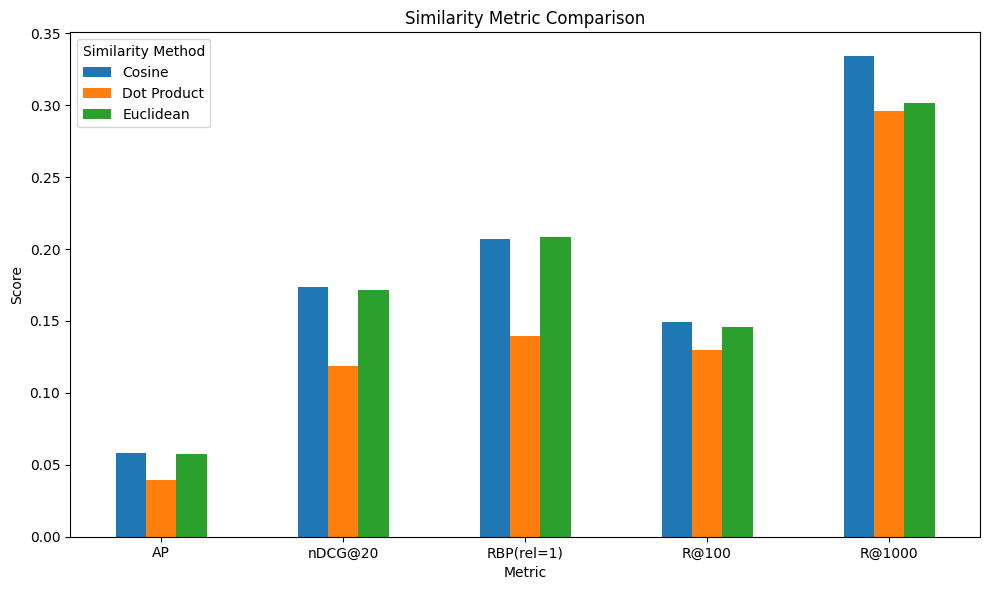

In [109]:
# Bar chart for comparison
comparison_df.set_index("Metric").plot(kind="bar", figsize=(10, 6))
plt.title("Similarity Metric Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Similarity Method")
plt.tight_layout()
plt.show()